**Method B**

In [2]:
pip install numpy scipy pywt scikit-learn pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [3]:
# 2. Load ECG5000 data
import pickle

train_path = r'C:\Users\MUSKAN\Downloads\Capstone_ML\ECG5000_train.pickle'
val_path   = r'C:\Users\MUSKAN\Downloads\Capstone_ML\ECG5000_validation.pickle'

with open(train_path, 'rb') as f:
    train = pickle.load(f)
with open(val_path, 'rb') as f:
    test  = pickle.load(f)

y_train, X_train = train[:,0].astype(int), train[:,1:]
y_test,  X_test  = test[:,0].astype(int),  test[:,1:]


In [4]:
# 3. Extract wavelet-energy features
import numpy as np, pywt

def wavelet_features(X, wavelet='db4', level=3):
    feats = []
    for beat in X:
        coeffs = pywt.wavedec(beat, wavelet, level=level)
        feats.append([np.sum(c**2) for c in coeffs])
    return np.array(feats)

X_train_feat = wavelet_features(X_train)
X_test_feat  = wavelet_features(X_test)


In [5]:
# 4. Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train_feat)
X_train_scaled = scaler.transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)


In [6]:
# 5. Train LDA and predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda    = LinearDiscriminantAnalysis().fit(X_train_scaled, y_train)
y_pred = lda.predict(X_test_scaled)


In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Train LDA and get predictions & probabilities
lda     = LinearDiscriminantAnalysis().fit(X_train_scaled, y_train)
y_pred  = lda.predict(X_test_scaled)
y_proba = lda.predict_proba(X_test_scaled)

# Compute metrics
acc_lda    = accuracy_score(y_test, y_pred)
prec_lda   = precision_score(y_test, y_pred, average='macro')
recall_lda = recall_score(y_test, y_pred, average='macro')
f1_lda     = f1_score(y_test, y_pred, average='macro')
auroc_lda  = roc_auc_score(y_test, y_proba, average='macro', multi_class='ovo')
cm         = confusion_matrix(y_test, y_pred)

# Print results
print("Model Performance (LDA):")
print(f"  Accuracy:          {acc_lda:.4f}")
print(f"  Precision (macro): {prec_lda:.4f}")
print(f"  Recall (macro):    {recall_lda:.4f}")
print(f"  F1 Score (macro):  {f1_lda:.4f}")
print(f"  AUROC (macro):     {auroc_lda:.2f}")
print("\nConfusion Matrix:")
print(cm)


Model Performance (LDA):
  Accuracy:          0.8473
  Precision (macro): 0.3370
  Recall (macro):    0.3697
  F1 Score (macro):  0.3524
  AUROC (macro):     0.68

Confusion Matrix:
[[737  43   0   0   1]
 [ 56 534   0   0   0]
 [  8  35   0   0   0]
 [ 13  62   0   0   0]
 [  5   6   0   0   0]]


C:\Users\MUSKAN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


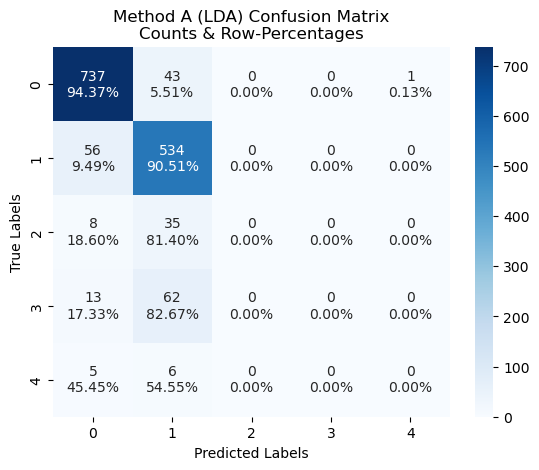

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1) Compute Method A’s confusion matrix
cf_matrix_lda = confusion_matrix(y_test, y_pred)

# 2) Normalize by row for percentages
cf_norm_lda = cf_matrix_lda.astype(float) / cf_matrix_lda.sum(axis=1)[:, np.newaxis]

# 3) Build the annotation labels
group_counts      = [f"{v:0.0f}"    for v in cf_matrix_lda.flatten()]
group_percentages = [f"{p:.2%}"     for p in cf_norm_lda.flatten()]
labels = np.asarray([f"{c}\n{p}" for c, p in zip(group_counts, group_percentages)])
labels = labels.reshape(cf_matrix_lda.shape)

# 4) Plot
plt.figure(dpi=100)
sns.heatmap(cf_matrix_lda,
            annot=labels,
            fmt='',
            cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Method A (LDA) Confusion Matrix\nCounts & Row-Percentages')
plt.show()
